In [1]:
import json

# read jsonl file
path = "/mnt/ssd/Projects/lmms-eval/outputs/hrbench_qwen3-1.7b-nothink-tqa/Qwen__Qwen3-1.7B/20251006_224314_samples_hrbench4k_tqa.jsonl"
with open(path, "r") as f:
    data = [json.loads(line) for line in f]

print(data[:5])  # print first 5 entries

[{'doc_id': 0, 'target': 'A', 'filtered_resps': ['<think>\nOkay, let\'s try to figure out the answer here. The question is asking what number is displayed above the entrance where the woman is standing. The context provided describes a scene with a woman holding a smartphone and touching the wall, wearing a white top with straps and a black wristband. There\'s a dark staircase behind her, a small rectangular sign on the wall with "27B" on a dark background, and a blue mailbox to the right.\n\nThe key part here is the sign on the wall. The context says, "a small rectangular sign displaying the characters \'27B\' on a dark background, with the numbers and letter appearing in a contrasting light color." So the number displayed is "27B". The options are A. 27B, B. 37B, C. 27D, D. 27E. \n\nThe question is asking for the number above the entrance. The sign is fixed to the wall, and the woman is standing at the entrance. The answer is directly given in the context as "27B". So the correct ans

In [2]:
# Reorganize the data entries
reorganized_data = {0: [], 1: []}
for e in data:
    score = e["average"]["gpt_score"]
    reorganized_data[score].append(
        {
            "question": e["input"],
            "target": e["target"],
            "response": e["filtered_resps"][0],
        }
    )

print(reorganized_data[0][0])  # print first entry of score 0

{'question': 'Is the mailbox on the left or right side of the woman?\nA. Right\nB. Directly above\nC. In front\nD. Left\n', 'target': 'A', 'response': "<think>\nOkay, let's try to figure out this question. So, the context describes a young woman standing next to a concrete wall with peeling paint and exposed bricks. She's wearing a sleeveless white top with lace trim and light denim shorts. She has a smartphone in her right hand and is looking to her left with a contemplative expression. Her left hand is resting on the wall, and she's carrying a white tote bag over her left shoulder. Behind her, there's a blue mailbox on the wall, and a staircase goes up into the darkness above.\n\nThe question is asking whether the mailbox is on the left or right side of the woman. The options are A. Right, B. Directly above, C. In front, D. Left.\n\nFirst, I need to visualize the scene. The woman is standing beside a concrete wall. The mailbox is mounted on the wall behind her. So, the mailbox is on 

In [3]:
print(len(reorganized_data[0]), len(reorganized_data[1]))  # print lengths of both lists

432 368


/mnt/ssd/Projects/lmms-eval/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


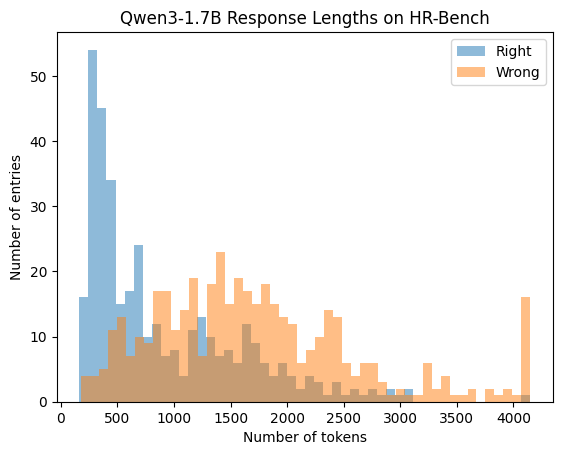

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-8B")
# draw histogram of lengths
import matplotlib.pyplot as plt

lengths_0 = []
lengths_1 = []
for score in [0, 1]:
    for entry in reorganized_data[score]:
        input_text = entry["question"] + " " + entry["response"]
        tokens = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=8192)
        if score == 0:
            lengths_0.append(tokens.input_ids.shape[1])
        else:
            lengths_1.append(tokens.input_ids.shape[1])

plt.hist(lengths_1, bins=50, alpha=0.5, label="Right")
plt.hist(lengths_0, bins=50, alpha=0.5, label="Wrong")
# Make y-axis break
plt.xlabel("Number of tokens")
plt.ylabel("Number of entries")
plt.legend()
plt.title("Qwen3-1.7B Response Lengths on HR-Bench")
plt.show()

In [6]:
# find the most used tokens in each score group
from collections import Counter

counter_0 = Counter()
counter_1 = Counter()
for score in [0, 1]:
    for entry in reorganized_data[score]:
        input_text = entry["question"] + " " + entry["response"]
        tokens = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=8192)
        if score == 0:
            counter_0.update(tokens.input_ids[0].tolist())
        else:
            counter_1.update(tokens.input_ids[0].tolist())

for token_id, count in counter_0.most_common(10):
    print(f"Token ID: {token_id}, Count in score 0: {count}, Token: {tokenizer.decode([token_id])}")
for token_id, count in counter_1.most_common(10):
    print(f"Token ID: {token_id}, Count in score 1: {count}, Token: {tokenizer.decode([token_id])}")

Token ID: 279, Count in score 0: 478688, Token:  the
Token ID: 13, Count in score 0: 354705, Token: .
Token ID: 11, Count in score 0: 315443, Token: ,
Token ID: 374, Count in score 0: 227156, Token:  is
Token ID: 13824, Count in score 0: 78999, Token:  Wait
Token ID: 220, Count in score 0: 75915, Token:  
Token ID: 1988, Count in score 0: 73631, Token:  But
Token ID: 4226, Count in score 0: 66611, Token:  answer
Token ID: 525, Count in score 0: 60446, Token:  are
Token ID: 323, Count in score 0: 56925, Token:  and
Token ID: 279, Count in score 1: 10384, Token:  the
Token ID: 13, Count in score 1: 8668, Token: .
Token ID: 11, Count in score 1: 5451, Token: ,
Token ID: 374, Count in score 1: 4653, Token:  is
Token ID: 576, Count in score 1: 3348, Token:  The
Token ID: 389, Count in score 1: 2059, Token:  on
Token ID: 264, Count in score 1: 2021, Token:  a
Token ID: 315, Count in score 1: 1832, Token:  of
Token ID: 304, Count in score 1: 1609, Token:  in
Token ID: 220, Count in score 1: 1